# Autoencoder Playground

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import operator
import random
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.datasets import MNIST
from torchvision import transforms

plt.style.use('ggplot')

## Data

In [3]:
data_root = "/tmp/"


transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,
        translate=(0.0, 0.05),
        scale=(0.90, 1.03),
        shear=(-5, 5)      
    ),
    transforms.ToTensor(),
])

train_data = MNIST(data_root, transform=transform, train=True, download=True)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=512,
    pin_memory=True,
    shuffle=True,
    num_workers=2,
)

val_data, test_data = torch.utils.data.random_split(
    MNIST(data_root, transform=transform, train=False, download=True), 
    [5000, 5000]
)
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=8196,
    pin_memory=True,
    shuffle=True,
    num_workers=2,
)

Sample the first image a few times to ensure transforms are sane:

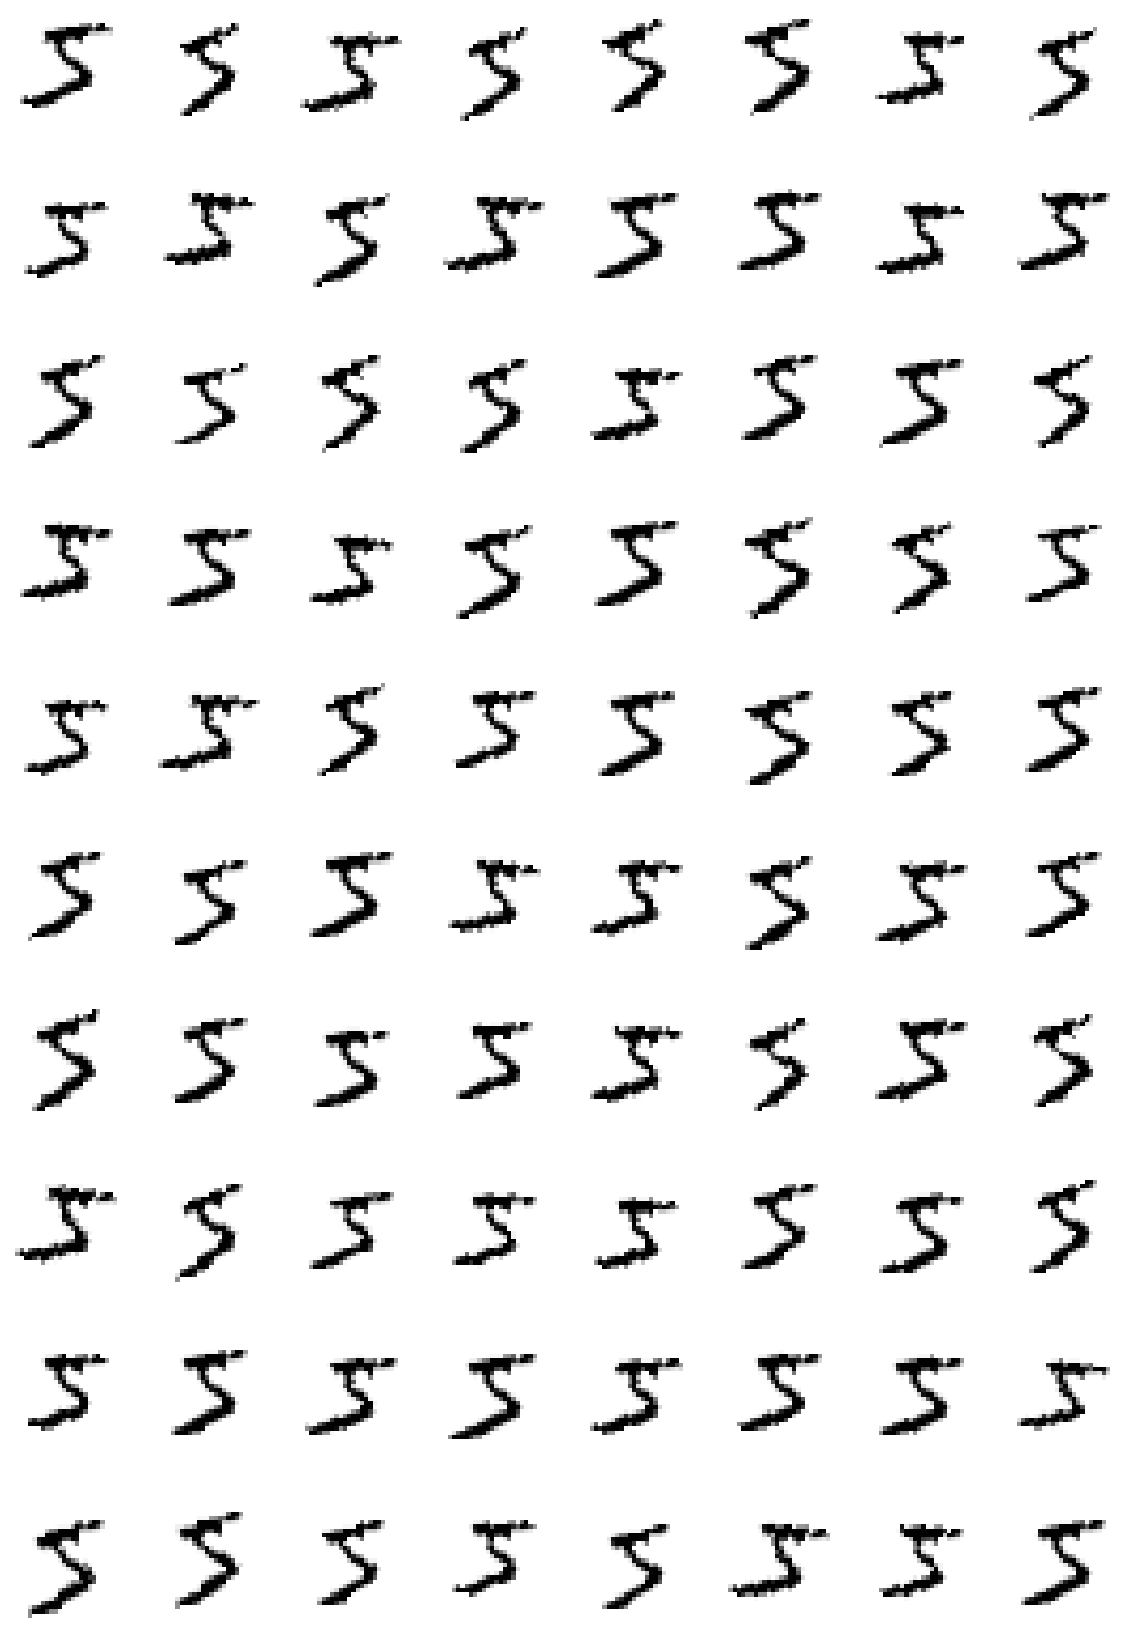

In [4]:
n_samples = 80

fig, axs = plt.subplots(
    nrows=math.ceil(n_samples / 8),
    ncols=8,
    figsize=(20, 30)
)

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(
        train_data[0][0].numpy().squeeze(),
        cmap='Greys'
    )
    ax.axis('off')
    ax.grid('equal')
    
plt.show()

## Encoder

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, is_vae, z_dim, in_channels=1):
        super().__init__()
        self.is_vae = is_vae
        self.z_dim = z_dim
        self.in_channels = in_channels
        self.channels = [32, 64, 64, 128, 256]
        self.kernel_size = [3, 3, 3, 3, 3]
        self.stride = [1, 2, 1, 2, 1]
        self._make_layers()
        
    def _make_layers(self):
        assert len(self.channels) == len(self.kernel_size) == len(self.stride)
        
        layers = []
        prev_c = self.in_channels
        for c, k, s in zip(self.channels, self.kernel_size, self.stride):
            layers.append(torch.nn.Conv2d(
                in_channels=prev_c,
                out_channels=c, 
                kernel_size=k,
                stride=s,
                padding=1,
                bias=False
            ))
            prev_c = c
            layers.append(torch.nn.BatchNorm2d(c))
            layers.append(torch.nn.ReLU(inplace=True))
        
        layers.append(torch.nn.Flatten())
        self.backbone = torch.nn.Sequential(*layers)
        
        features = prev_c*int(28/reduce(operator.mul, self.stride))**2
        
        if self.is_vae:
            self.mu = torch.nn.Linear(
                in_features=features,
                out_features=self.z_dim
            )
            self.log_var = torch.nn.Linear(
                in_features=features,
                out_features=self.z_dim
            )
        else:
            self.out = torch.nn.Linear(
                in_features=features,
                out_features=self.z_dim
            )
        
    def forward(self, x):
        out = self.backbone(x)
        if self.is_vae:
            mu = self.mu(out)
            log_var = self.log_var(out)
            return torch.normal(mean=mu, std=torch.exp(log_var / 2))
        return self.out(out)

## Decoder

In [6]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x):
        return self.fn(x)

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, z_dim, in_channels):
        super().__init__()
        self.z_dim = z_dim
        self.in_channels = in_channels
        self.channels = [128, 64, 64, 32, 1]
        self.kernel_size = [3, 3, 3, 3, 3]
        self.stride = [1, 2, 1, 2, 1]
        self._make_layers()
        
    def _make_layers(self):
        assert len(self.channels) == len(self.kernel_size) == len(self.stride)
        
        layers = []
        
        in_dim = int(28/reduce(operator.mul, self.stride))
        
        layers.append(
            torch.nn.Linear(
                self.z_dim, 
                self.in_channels*in_dim**2
            )
        )
        
        layers.append(
            Lambda(lambda x: x.view(-1, self.in_channels, in_dim, in_dim))
        )
        
        prev_c = self.in_channels
        for i, (c, k, s) in enumerate(zip(self.channels, self.kernel_size, self.stride)):
            layers.append(torch.nn.ConvTranspose2d(
                in_channels=prev_c,
                out_channels=c, 
                kernel_size=k,
                stride=s,
                padding=1,
                output_padding=1 if s > 1 else 0,
                bias=False
            ))
            prev_c = c
            layers.append(torch.nn.BatchNorm2d(c))
            
            if i != len(self.channels) - 1:
                layers.append(torch.nn.ReLU(inplace=True))
            else:
                layers.append(torch.nn.Sigmoid())
        self.backbone = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.backbone(x)

## Model

In [8]:
encoder = Encoder(is_vae=False, z_dim=2).cuda()
decoder = Decoder(z_dim=2, in_channels=256).cuda()

In [9]:
encoder

Encoder(
  (backbone): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [10]:
decoder

Decoder(
  (backbone): Sequential(
    (0): Linear(in_features=2, out_features=12544, bias=True)
    (1): Lambda()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13)

In [11]:
model = torch.nn.Sequential(encoder, decoder)

## Loss

In [12]:
loss_fn = torch.nn.MSELoss()

## Optimizer

In [13]:
opt = torch.optim.Adam(
    params=model.parameters(),
    lr=0.9
)

In [14]:
sched = None

## Training Loop

In [15]:
epochs = 15

total_steps = len(train_loader)

In [16]:
print_every = max(1, math.floor(0.1*total_steps))  # print output every N%
valid_every = max(1, math.floor(0.5*total_steps))  # validate after every N%

print(print_every)
print(valid_every)

11
59


In [17]:
best_loss = float("inf")
best_model = None

for epoch in range(epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.cuda()

        model.zero_grad()

        out = model(x)

        loss = loss_fn(out, x)

        loss.backward()

        opt.step()

        if sched is not None:
            sched.step(loss)
            
        if i % valid_every == 0:
            model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for val_step, (x, _) in enumerate(val_loader, 1):
                    x = x.cuda()
                    val_loss += loss_fn(model(x), x)
                val_loss /= val_step
                
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = model.state_dict()
                
            model.train()
            
        if i % print_every == 0:
            print(f"{epoch:2}, {i:4}, {loss.item():.4f}, {best_loss:.4f}")


 0,    0, 0.2683, 0.8592
 0,   11, 0.0725, 0.8592
 0,   22, 0.0623, 0.8592
 0,   33, 0.0631, 0.8592
 0,   44, 0.0613, 0.8592
 0,   55, 0.0605, 0.8592
 0,   66, 0.0600, 0.1298
 0,   77, 0.0610, 0.1298
 0,   88, 0.0607, 0.1298
 0,   99, 0.0574, 0.1298
 0,  110, 0.0578, 0.1298
 1,    0, 0.0585, 0.0579
 1,   11, 0.0564, 0.0579
 1,   22, 0.0572, 0.0579
 1,   33, 0.0561, 0.0579
 1,   44, 0.0551, 0.0579
 1,   55, 0.0556, 0.0579
 1,   66, 0.0551, 0.0579
 1,   77, 0.0552, 0.0579
 1,   88, 0.0526, 0.0579
 1,   99, 0.0542, 0.0579
 1,  110, 0.0553, 0.0579
 2,    0, 0.0547, 0.0565
 2,   11, 0.0543, 0.0565
 2,   22, 0.0543, 0.0565
 2,   33, 0.0539, 0.0565
 2,   44, 0.0529, 0.0565
 2,   55, 0.0529, 0.0565
 2,   66, 0.0518, 0.0543
 2,   77, 0.0531, 0.0543
 2,   88, 0.0539, 0.0543
 2,   99, 0.0526, 0.0543
 2,  110, 0.0520, 0.0543
 3,    0, 0.0532, 0.0526
 3,   11, 0.0512, 0.0526
 3,   22, 0.0524, 0.0526
 3,   33, 0.0509, 0.0526
 3,   44, 0.0513, 0.0526
 3,   55, 0.0506, 0.0526
 3,   66, 0.0525, 0.0522


In [19]:
model.load_state_dict(best_model)
model.eval();

## Analysis

In [20]:
def plot_examples(dataset, n_examples=10):
    fig, axs = plt.subplots(2, n_examples, figsize=(40, 6))

    for i, (x, _) in enumerate(random.sample(list(dataset), n_examples)):
        axs[0][i].imshow(x.squeeze().numpy(), cmap="Greys")
        axs[0][i].axis('off')

        x = torch.unsqueeze(x, 0)
        with torch.no_grad():
            out = model(x.cuda()).squeeze().cpu().numpy()

        axs[1][i].imshow(out, cmap="Greys")
        axs[1][i].axis('off')

    plt.show()

In [21]:
def plot_latent(dataset):
    points = []
    labels = []
    for x, y in dataset:
        x = torch.unsqueeze(x, 0)
        with torch.no_grad():
            out = encoder(x.cuda()).squeeze().cpu().numpy()
            
        points.append(out)
        labels.append(y)
        
    points = np.array(points)
    labels = np.array(labels)
    
    fig = plt.figure(
        figsize=(10, 10),
    )
    ax = fig.add_subplot()
    
    ax.set_xlim(points[:,0].min(), points[:,0].max())
    ax.set_ylim(points[:,1].min(), points[:,1].max())
    ax.set_aspect('equal')
    
    scatter = ax.scatter(
        points[:, 0], 
        points[:, 1],
        c=labels,
        s=3,
        cmap='tab10'
    )
    
    ax.legend(*scatter.legend_elements(prop='colors'))
    plt.show()

### Training Set

In [22]:
train_data.transform = transforms.ToTensor()   # disable data augmentation

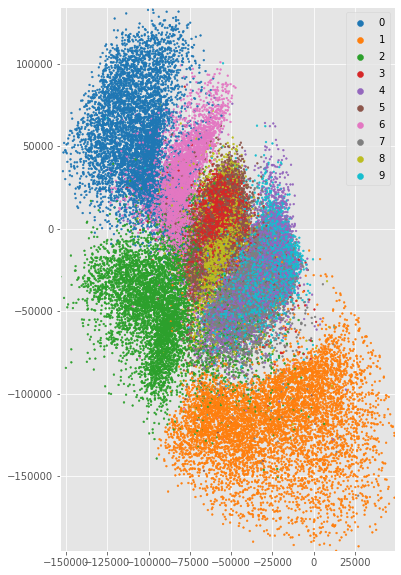

In [23]:
plot_latent(train_data)

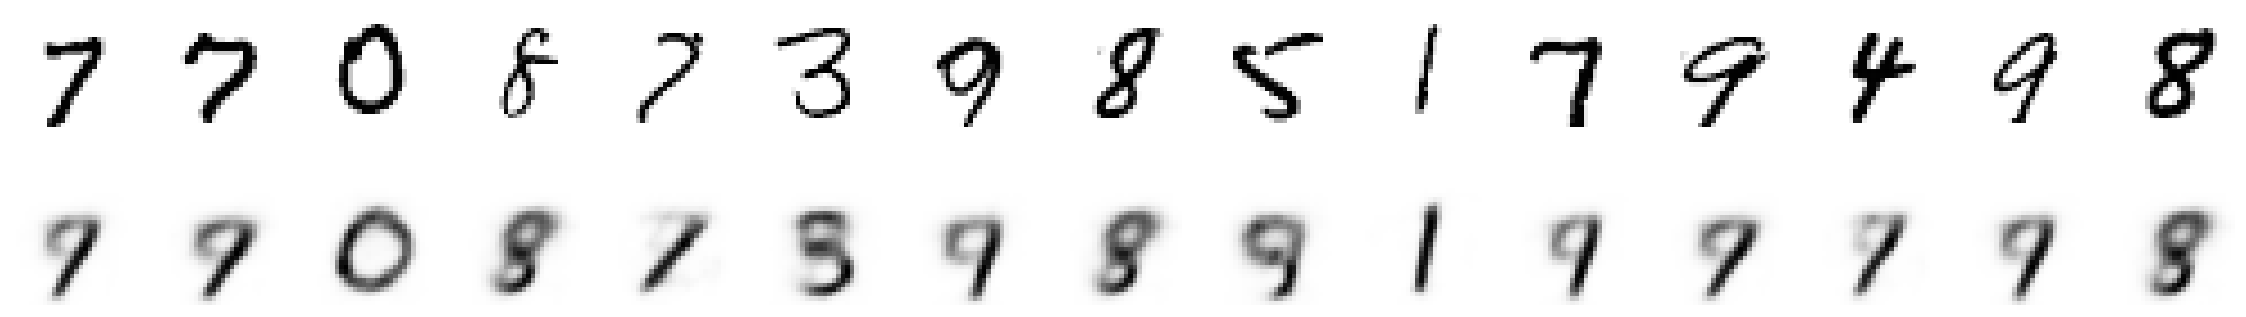

In [24]:
plot_examples(train_data, n_examples=15)

## Validation Set

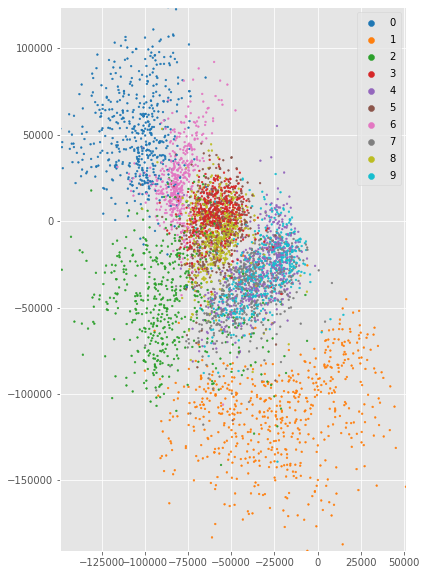

In [25]:
plot_latent(val_data)

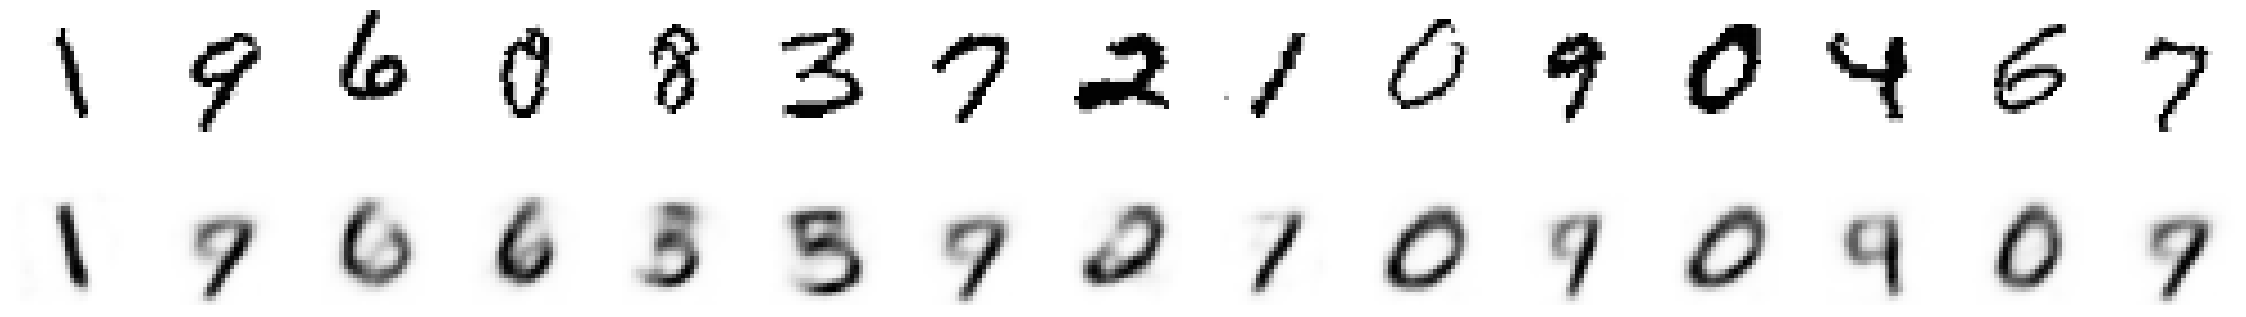

In [26]:
plot_examples(val_data, n_examples=15)

### Test Set

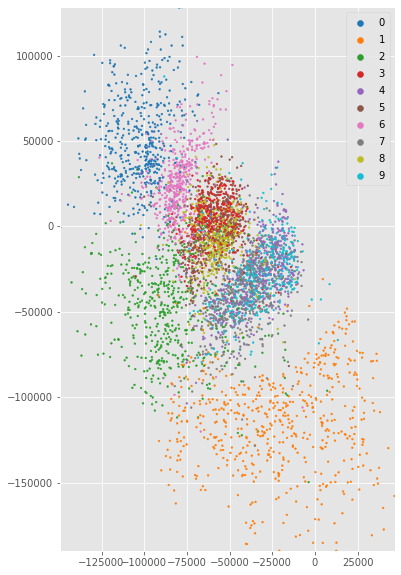

In [27]:
plot_latent(test_data)

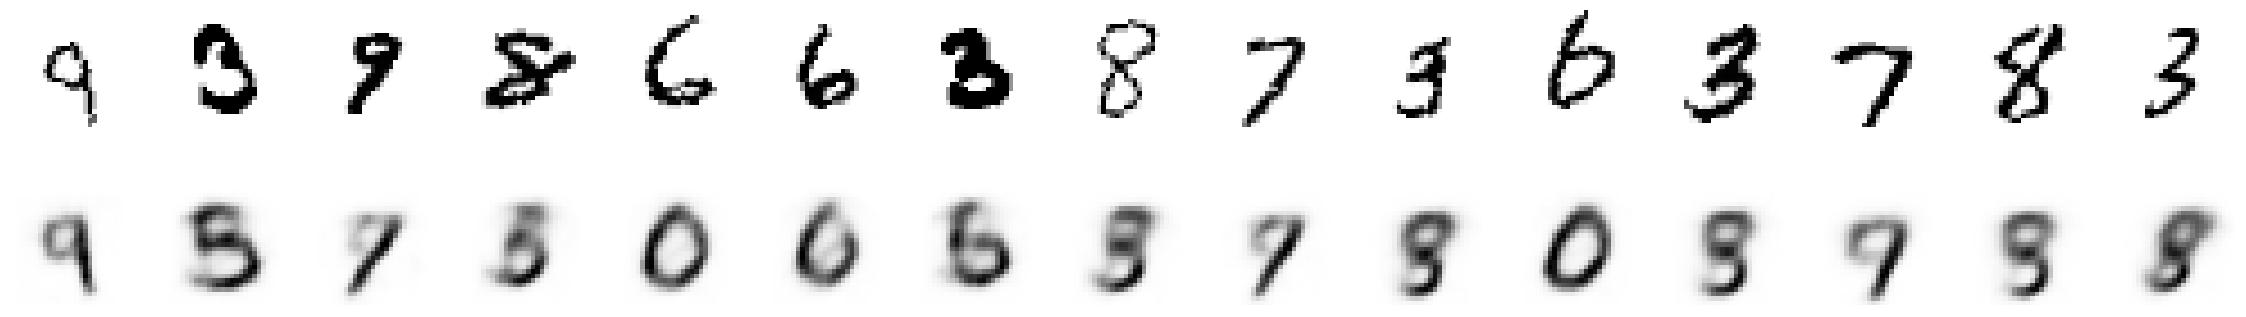

In [28]:
plot_examples(test_data, n_examples=15)

### Grid

In [35]:
def plot_grid(min_x, max_x, min_y, max_y, every_x, every_y, fig_size):
    Y, X = np.mgrid[min_y:max_y:every_y, min_x:max_x:every_x]
    samples = torch.tensor(np.vstack([X.ravel(), Y.ravel()[::-1]]), dtype=torch.float32).T
    
    fig, axs = plt.subplots(*X.shape)
    axs = axs.flatten()

    for x, ax in zip(samples, axs):
        x = torch.unsqueeze(x, 0)
        with torch.no_grad():
            out = decoder(x.cuda()).squeeze().cpu().numpy()

        ax.imshow(out, cmap='Greys')
        ax.axis('off')
        
    fig.set_size_inches(fig_size)

    plt.show()

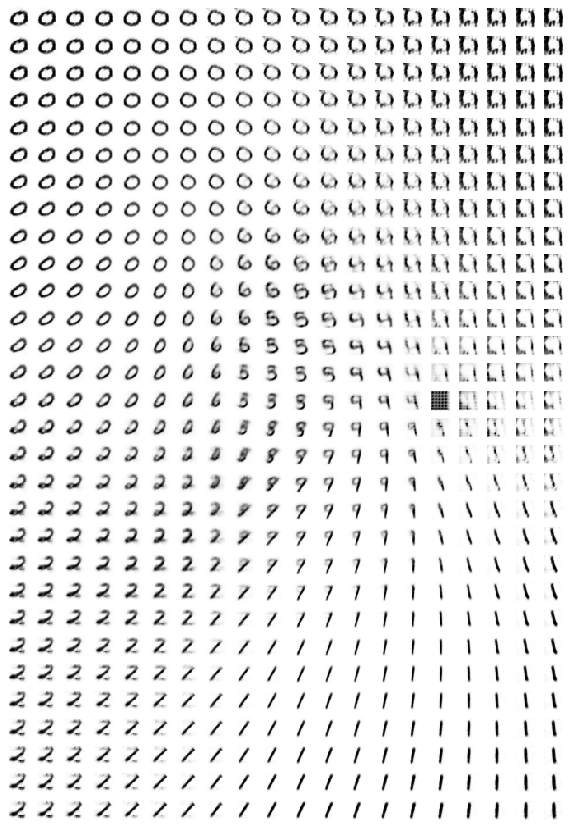

In [38]:
plot_grid(
    min_x=-150000, 
    max_x=50000, 
    min_y=-150000, 
    max_y=150000, 
    every_x=10000, 
    every_y=10000,
    fig_size=(10, 15)
)